<a href="https://colab.research.google.com/github/REZAKAZAZI00/Pattern_Recognition/blob/main/Pattern_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
import re
from collections import Counter, defaultdict
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
dataset = load_dataset("nbertagnolli/counsel-chat")

def build_dialogue(example):
    title = example.get("questionTitle") or ""
    question = example.get("questionText") or ""
    example["dialogue_text"] = (title + "\n\n" + question).strip()
    return example

dataset = dataset.map(build_dialogue)

Repo card metadata block was not found. Setting CardData to empty.


In [ ]:
NRC_PATH = "/content/drive/MyDrive/NRC/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
EMOTIONS = ["anger","anticipation","disgust","fear","joy","sadness","surprise","trust"]

def load_nrc(path):
    nrc = defaultdict(list)
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) != 3:
                continue
            word, emo, flag = parts
            if emo in EMOTIONS and flag == "1":
                nrc[word].append(emo)
    return nrc

nrc_lexicon = load_nrc(NRC_PATH)

In [ ]:
# ===============================
# 4) Functions to compute emotion vector
# ===============================
def clean_text(t):
    t = t.lower()
    t = re.sub(r"[^a-z\s]", " ", t)
    return re.sub(r"\s+", " ", t).strip()

def emotion_vector(text):
    tokens = clean_text(text).split()
    cnt = Counter()
    for tok in tokens:
        if tok in nrc_lexicon:
            for emo in nrc_lexicon[tok]:
                cnt[emo] += 1

    vec = np.zeros(8, dtype=np.float32)
    total = sum(cnt.values())
    if total == 0:
        return vec
    for i, emo in enumerate(EMOTIONS):
        vec[i] = cnt[emo] / total
    return vec

def emotion_label(vec):
    return int(np.argmax(vec))


In [ ]:
# ===============================
# 5) Convert dataset → DataFrame
# ===============================
rows = []

for row in dataset["train"]:
    text = row["dialogue_text"]
    tl = len(text)
    wc = len(clean_text(text).split())
    emo_vec = emotion_vector(text)
    label = emotion_label(emo_vec)
    rows.append({
        "text_length": tl,
        "word_count": wc,
        **{f"emo_{i}": emo_vec[i] for i in range(8)},
        "label": label
    })

df = pd.DataFrame(rows)
print(df.head())


   text_length  word_count     emo_0     emo_1     emo_2     emo_3     emo_4  \
0          418          81  0.166667  0.111111  0.111111  0.166667  0.111111   
1          418          81  0.166667  0.111111  0.111111  0.166667  0.111111   
2          418          81  0.166667  0.111111  0.111111  0.166667  0.111111   
3          418          81  0.166667  0.111111  0.111111  0.166667  0.111111   
4          418          81  0.166667  0.111111  0.111111  0.166667  0.111111   

      emo_5  emo_6     emo_7  label  
0  0.277778    0.0  0.055556      5  
1  0.277778    0.0  0.055556      5  
2  0.277778    0.0  0.055556      5  
3  0.277778    0.0  0.055556      5  
4  0.277778    0.0  0.055556      5  


In [ ]:
# ===============================
# 6) Normalization
# ===============================
features = df.drop(columns=["label"]).values

### Min-Max
scaler_minmax = MinMaxScaler()
minmax_norm = scaler_minmax.fit_transform(features)

### Z-score
scaler_zscore = StandardScaler()
zscore_norm = scaler_zscore.fit_transform(features)

### Decimal Scaling
max_abs = np.abs(features).max()
j = int(np.ceil(np.log10(max_abs)))
decimal_norm = features / (10 ** j)

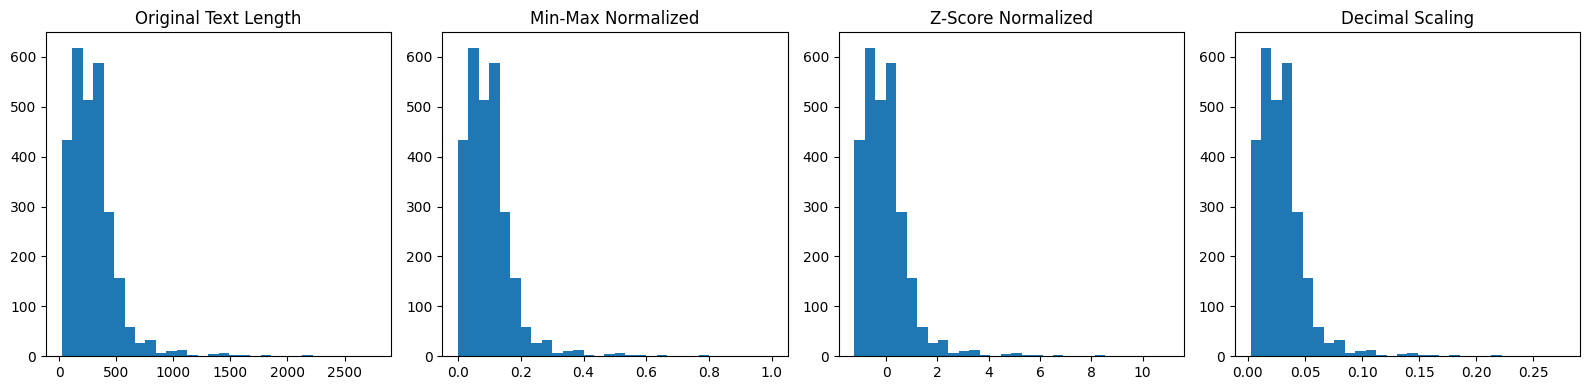

In [ ]:
# ===============================
# 7) PLOT – Before and After Normalization
# ===============================

plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
plt.hist(df["text_length"], bins=30)
plt.title("Original Text Length")

plt.subplot(1,4,2)
plt.hist(minmax_norm[:,0], bins=30)
plt.title("Min-Max Normalized")

plt.subplot(1,4,3)
plt.hist(zscore_norm[:,0], bins=30)
plt.title("Z-Score Normalized")

plt.subplot(1,4,4)
plt.hist(decimal_norm[:,0], bins=30)
plt.title("Decimal Scaling")

plt.tight_layout()
plt.show()


In [ ]:
# ===============================
# 8) Naive Bayes (Best on Z-score)
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    zscore_norm, df["label"], test_size=0.3, random_state=42
)

model = GaussianNB()
model.fit(X_train, y_train)
pred = model.predict(X_test)

print("\n📌 Naive Bayes Accuracy:", model.score(X_test, y_test))
print("\nClassification Report:")
print(classification_report(y_test, pred, zero_division=0))


📌 Naive Bayes Accuracy: 0.5942376950780313

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.50      0.57       257
           1       0.92      0.62      0.74       144
           2       1.00      0.25      0.40         8
           3       0.70      0.57      0.63        91
           4       0.76      0.36      0.49        61
           5       0.85      0.82      0.83       147
           6       0.01      1.00      0.02         2
           7       0.72      0.64      0.68       123

    accuracy                           0.59       833
   macro avg       0.70      0.60      0.54       833
weighted avg       0.76      0.59      0.66       833



## 9) Support Vector Machine (SVM)

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize and train the SVM model
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions on the test set
svm_pred = svm_model.predict(X_test)

# Evaluate the SVM model
print("\n📌 SVM Accuracy:", accuracy_score(y_test, svm_pred))
print("\nClassification Report (SVM):")
print(classification_report(y_test, svm_pred, zero_division=0))


📌 SVM Accuracy: 0.9519807923169268

Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       257
           1       0.99      0.96      0.97       144
           2       1.00      0.38      0.55         8
           3       0.97      0.92      0.94        91
           4       0.93      0.92      0.93        61
           5       0.93      0.96      0.94       147
           6       1.00      0.50      0.67         2
           7       0.92      0.97      0.94       123

    accuracy                           0.95       833
   macro avg       0.96      0.82      0.86       833
weighted avg       0.95      0.95      0.95       833



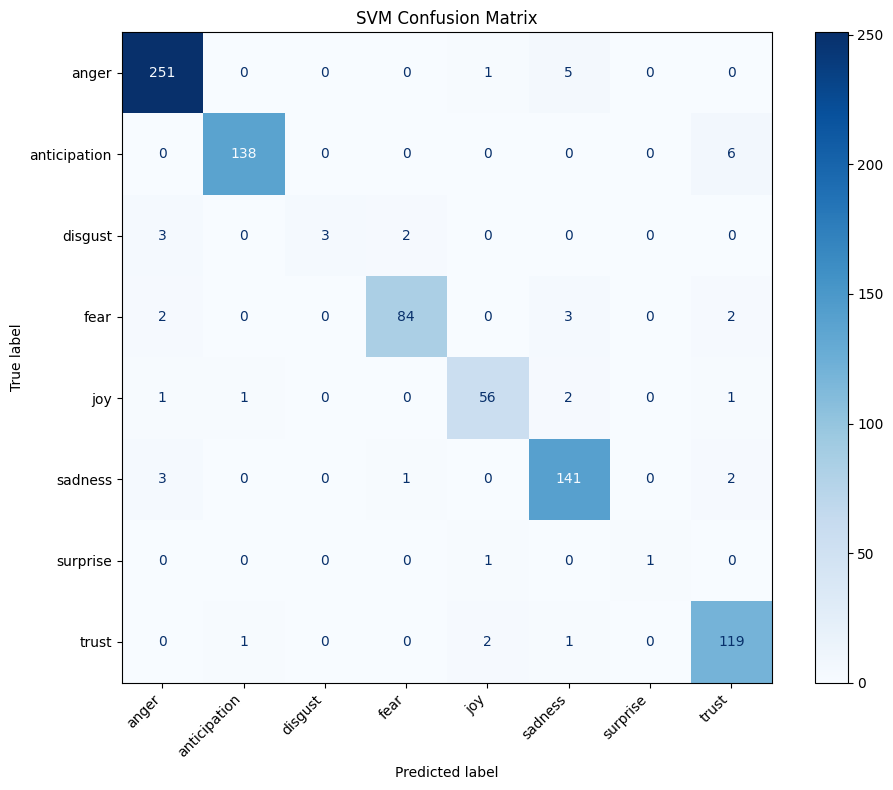

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, svm_pred, labels=svm_model.classes_)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=EMOTIONS)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title("SVM Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()